<a href="https://colab.research.google.com/github/Tashika-Wijesooriya/research-/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import class_weight

# 1. Load CSV
df = pd.read_csv("/content/drive/MyDrive/echo/MeasurementsList.csv")

# 2. Filter for relevant measurements (IVSd, LVPWd)
df_lvh = df[df["Calc"].isin(["IVSd", "LVPWd"])]

# 3. Create Labels (Max value per video)
labels = (
    df_lvh
    .groupby("HashedFileName")["CalcValue"]
    .max()
    .reset_index()
)

# 4. Define Threshold (>= 1.1 is LVH)
labels["label"] = (labels["CalcValue"] >= 1.1).astype(int)

print("Label distribution:\n", labels["label"].value_counts())

Label distribution:
 label
0    7288
1    4414
Name: count, dtype: int64


In [75]:
import cv2

IMG_SIZE = 112      # image height & width
MAX_FRAMES = 16     # number of frames per video

def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while len(frames) < MAX_FRAMES:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize and Normalize
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame = frame.astype('float32') / 255.0
        frames.append(frame)

    cap.release()

    # Padding: If video is too short, repeat the last frame
    while len(frames) < MAX_FRAMES:
        frames.append(frames[-1])

    # Truncating: If video is too long (rare but possible), take first 16
    return np.array(frames[:MAX_FRAMES])

In [76]:
X = []
y = []

VIDEO_PATH = "/content/drive/MyDrive/echo/set 1"

print("Loading videos... this may take a moment.")

for video_file in os.listdir(VIDEO_PATH):
    if not video_file.endswith(".avi"):
        continue

    video_id = video_file.replace(".avi", "")

    # Match file to label
    label_row = labels[labels["HashedFileName"] == video_id]

    if len(label_row) == 0:
        continue  # skip if no label found

    # Load video
    video_path = os.path.join(VIDEO_PATH, video_file)
    video_data = load_video(video_path)

    X.append(video_data)
    y.append(label_row["label"].values[0])

X = np.array(X)
y = np.array(y)

print("Data Loaded.")
print("X shape:", X.shape)
print("y shape:", y.shape)

Loading videos... this may take a moment.
Data Loaded.
X shape: (561, 16, 112, 112, 3)
y shape: (561,)


In [77]:
from sklearn.model_selection import train_test_split

# 1. Stratified Split (keeps same ratio of LVH/Normal in both sets)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2. Compute Class Weights
# This tells the model: "Pay more attention to the class with fewer samples"
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights_vals))

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Class Weights: {class_weights_dict}")

Training samples: 448
Validation samples: 113
Class Weights: {0: np.float64(0.8115942028985508), 1: np.float64(1.302325581395349)}


In [78]:
import tensorflow as tf
from scipy import ndimage
import random

class VideoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X_set, y_set, batch_size, augment=False):
        self.X, self.y = X_set, y_set
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(self.X))

    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = self.X[indices]
        y_batch = self.y[indices]

        if self.augment:
            X_batch = self._augment_batch(X_batch)

        return X_batch, y_batch

    def _augment_batch(self, batch):
        augmented_batch = []
        for video in batch:
            # Random Horizontal Flip
            if random.random() > 0.5:
                video = np.flip(video, axis=2)

            # Random Rotation (-10 to 10 degrees)
            if random.random() > 0.5:
                angle = random.uniform(-10, 10)
                # Rotate spatial dims (height/width) only
                video = ndimage.rotate(video, angle, axes=(1, 2), reshape=False, mode='nearest')

            augmented_batch.append(video)
        return np.array(augmented_batch)

# Create Generators
BATCH_SIZE = 8
train_gen = VideoDataGenerator(X_train, y_train, batch_size=BATCH_SIZE, augment=True)
val_gen = VideoDataGenerator(X_val, y_val, batch_size=BATCH_SIZE, augment=False)

In [79]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

def build_cnn_lstm_model():
    model = Sequential()

    # Input Shape: (Frames, Height, Width, Channels)
    model.add(Input(shape=(16, 112, 112, 3)))

    # --- CNN Part (Spatial Features) ---
    # We wrap Conv2D in TimeDistributed so it applies to every frame
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(GlobalAveragePooling2D())) # Collapses spatial dims

    # --- LSTM Part (Temporal/Motion Features) ---
    # The LSTM receives a sequence of 16 feature vectors
    model.add(LSTM(64, return_sequences=False, dropout=0.3))

    # --- Classification ---
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

model_lstm = build_cnn_lstm_model()
model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 112, 112,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 112, 112,   │           128 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 16, 56, 56, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 16, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 16, 28, 28,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 16, 28, 28,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 16, 128)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,777 (577.25 KB)

 Trainable params: 147,329 (575.50 KB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 603ms/step - accuracy: 0.4501 - loss: 1.3334 - val_accuracy: 0.4196 - val_loss: 1.3139 - learning_rate: 1.0000e-04
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 527ms/step - accuracy: 0.4900 - loss: 1.2803 - val_accuracy: 0.5536 - val_loss: 1.2816 - learning_rate: 1.0000e-04
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 515ms/step - accuracy: 0.5587 - loss: 1.2513 - val_accuracy: 0.4732 - val_loss: 1.2655 - learning_rate: 1.0000e-04
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 540ms/step - accuracy: 0.5481 - loss: 1.2263 - val_accuracy: 0.5446 - val_loss: 1.2165 - learning_rate: 1.0000e-04
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 549ms/step - accuracy: 0.5976 - loss: 1.1809 - val_accuracy: 0.4732 - val_loss: 1.2146 - learning_rate: 1.0000e-04
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 517ms/step - accuracy: 0.5717 - loss: 1.1688 - val_accuracy: 0.6071 - val_loss: 1.1521 - learning_rate: 1.0000e-04
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 532ms/step - acc

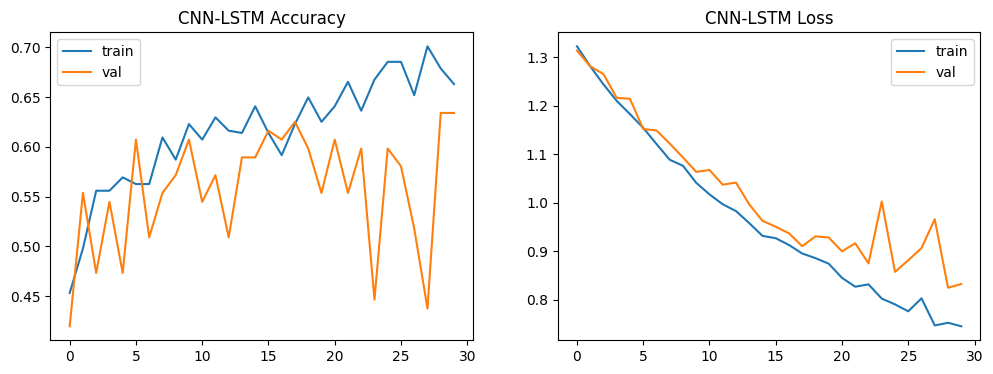

In [80]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Compile
model_lstm.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Train using the EXISTING generators (no need to reload data)
history_lstm = model_lstm.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

# Plot Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='train')
plt.plot(history_lstm.history['val_accuracy'], label='val')
plt.title("CNN-LSTM Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='train')
plt.plot(history_lstm.history['val_loss'], label='val')
plt.title("CNN-LSTM Loss")
plt.legend()
plt.show()

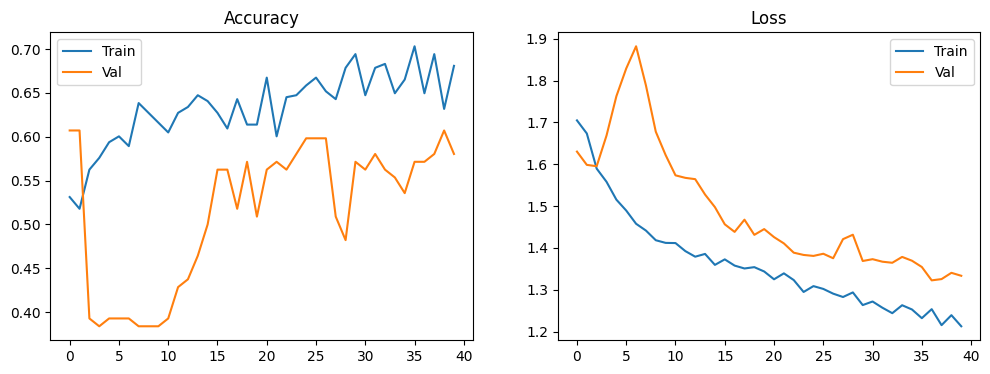

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
              precision    recall  f1-score   support

      Normal       0.66      0.61      0.63        69
         LVH       0.45      0.50      0.47        44

    accuracy                           0.57       113
   macro avg       0.55      0.55      0.55       113
weighted avg       0.58      0.57      0.57       113



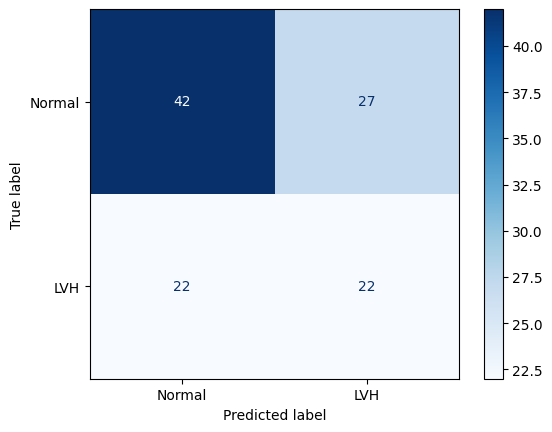

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Plot Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

# 2. Generate Predictions
# Note: We predict on X_val directly to match indices easily
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

# 3. Report
print(classification_report(y_val, y_pred, target_names=["Normal", "LVH"]))

# 4. Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "LVH"])
disp.plot(cmap="Blues")
plt.show()